# QWEN IMAGE EDIT bitsandbytes | Lowest VRAM configuration <br> (~17GB of VRAM)

In [1]:
import torch
from transformers import BitsAndBytesConfig as TransformersBitsAndBytesConfig
from transformers import Qwen2_5_VLForConditionalGeneration

from diffusers import BitsAndBytesConfig as DiffusersBitsAndBytesConfig
from diffusers import QwenImageEditPipeline, QwenImageTransformer2DModel
from diffusers.utils import load_image


## Model Paths

In [2]:
model_id = "/path/to/weights/Qwen-Image-Edit"
lora_path = "/path/to/weights/Qwen-Lora/Qwen-Image-Lightning-8steps-V1.1.safetensors"
# lora_path "/path/to/weights/Qwen-Lora/Qwen-Image-Lightning-4steps-V1.0.safetensors"

## Configuration of Weights

In [3]:
torch_dtype = torch.bfloat16
device = "cuda"

quantization_config = DiffusersBitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_skip_modules=["transformer_blocks.0.img_mod"],
)
transformer = QwenImageTransformer2DModel.from_pretrained(
    model_id,
    subfolder="transformer",
    quantization_config=quantization_config,
    torch_dtype=torch_dtype,
)
transformer = transformer.to("cpu")

quantization_config = TransformersBitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

text_encoder = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id,
    subfolder="text_encoder",
    quantization_config=quantization_config,
    torch_dtype=torch_dtype,
)
text_encoder = text_encoder.to("cpu")

pipe = QwenImageEditPipeline.from_pretrained(
    model_id, transformer=transformer, 
    text_encoder=text_encoder, 
    torch_dtype=torch_dtype
)


pipe.enable_model_cpu_offload()



Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

## Configuration of Lora Weights

In [4]:
# optionally load LoRA weights to speed up inference
pipe.load_lora_weights(lora_path)

## Load Input Image

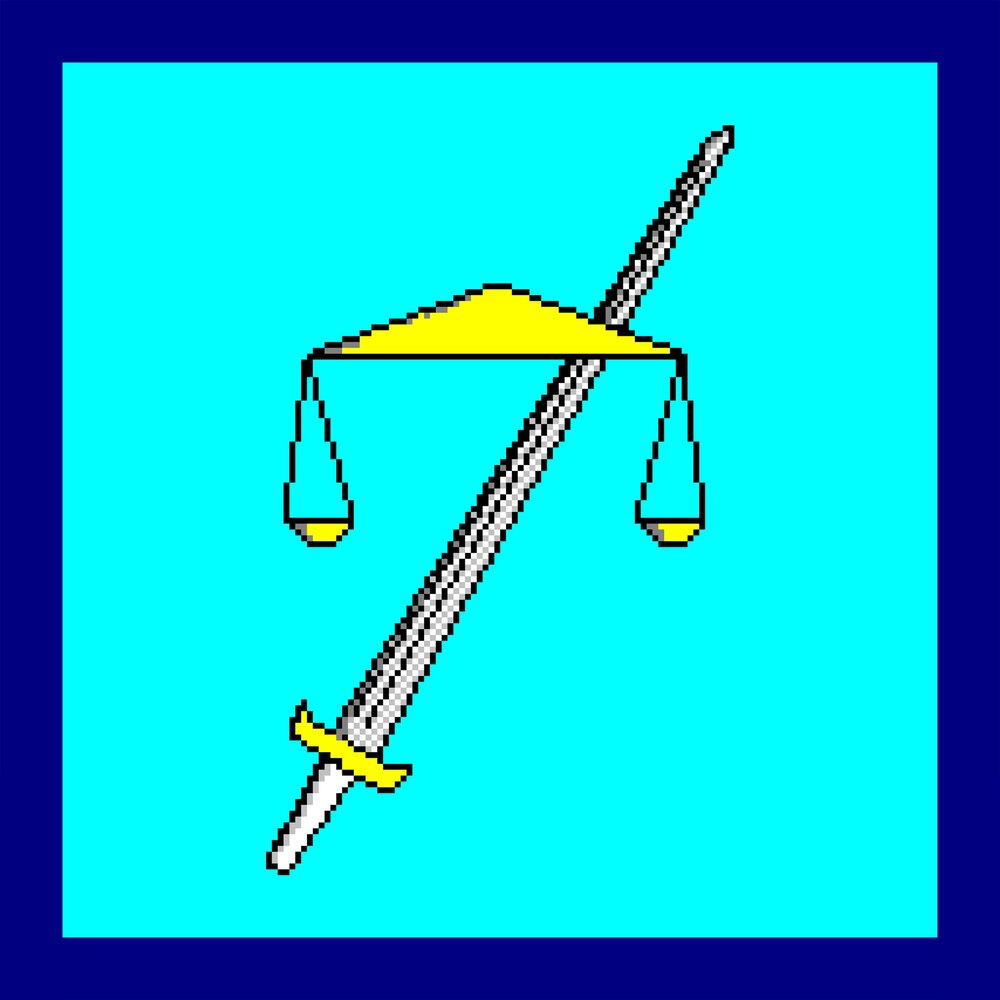

In [23]:
image = load_image(
    "../assets/temple.jpeg"
).convert("RGB")
image


## Inference Settings

In [24]:
prompt = (
    "change the rendering of the image into a realistic rendering, preserving the concepts."
    "The sword should be rendered as a real sword. The scale as a real scale."
    "Turn the light blue into a beautiful sky."
    "Turn the dark blue border into a metallic rendering"
)
seed = 42 # The meaning of life.
steps = 8 # 4 if using 4-Step Lora

## Inference

In [25]:
generator = torch.Generator(device="cuda").manual_seed(seed)
# change steps to 8 or 4 if you used the lighting loras
image = pipe(
    image=image, 
    prompt=prompt, 
    num_inference_steps=steps,
    generator=generator
).images[0]



  0%|          | 0/8 [00:00<?, ?it/s]

## Output

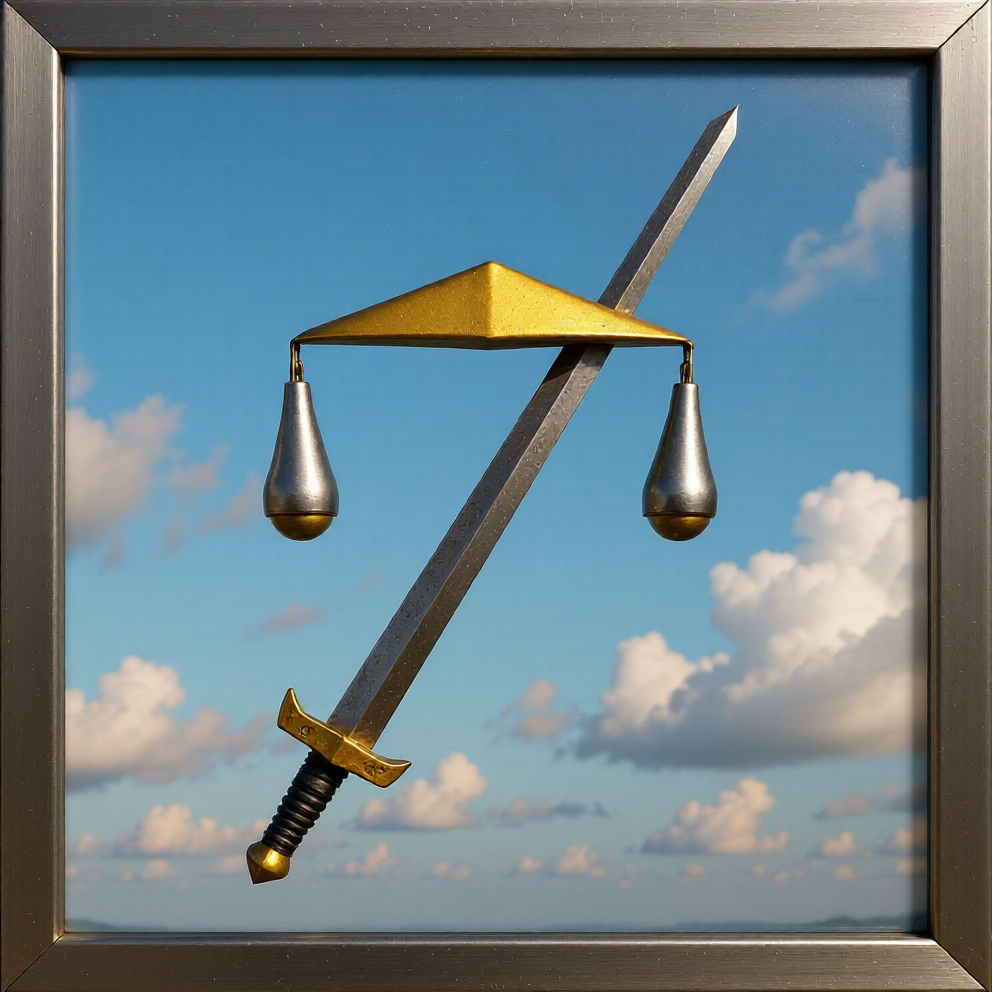

In [26]:
# image.save("qwenimageedit.png")
image